In [78]:
import torch.nn as nn
from torchsummary import summary

class MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x


class MobileNetV1_conv3x3(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1_conv3x3, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_bn(32, 64, 1),
            conv_bn(64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [83]:
from time import time
import numpy as np
import torch

device = 'cuda'
# model = MobileNetV1(3, 1000).to(device)
model = MobileNetV1_conv3x3(3, 1000).to(device)
results_3x3 = {}

for batch_size in [1, 2, 4, 8, 16]:
    results_3x3[batch_size] = []
    #x = torch.randn(batch_size, 3, 224, 224, device=device)
    x = torch.randn(batch_size, 3, 512, 512, device=device)
    
    for i in range(15):
        torch.cuda.synchronize()
        start = time()
        y = model(x).contiguous()
        y[0][0].item()
        torch.cuda.synchronize()
        if i < 2: continue # Warming up
        results_3x3[batch_size].append(time() - start)
        
    results_3x3[batch_size] = np.mean(results_3x3[batch_size])

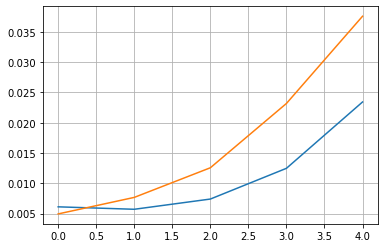

In [85]:
import matplotlib.pyplot as plt

plt.plot(list(results.values()))
plt.plot(list(results_3x3.values()))
plt.grid()

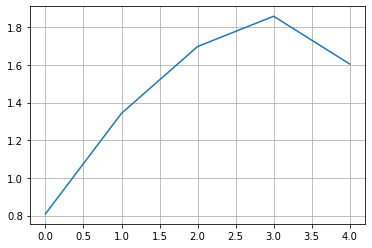

In [86]:
import matplotlib.pyplot as plt

plt.plot([a/b for a,b in zip(results_3x3.values(), results.values())])
plt.grid()